1. Modifica una red preentrenada de torchvision.models para el problema de clasificación de 10 dígitos.
2. Refina la red con y sin data augmentation (2 modelos).
3. Entrena la misma red desde cero (con los pesos inicializados aleatoriamente), con y sin data augmentation (2 modelos).
4. Compara y comenta los resultados.

In [1]:
from torchvision import datasets
from torchvision import models
from torchvision import transforms as t
from torch import nn
from torch.utils.data import DataLoader
import torch

# CARGA DE DATOS

In [2]:
mytransforms = t.Compose([
    t.Resize((128, 128)),
    t.ToTensor(),
    # Antes de usar Normalize, se debe de transformar a tensor
    t.Normalize((0.5,), (0.5,))])

In [3]:
route = "/home/clown/2-semester/vision_individual"
train = datasets.MNIST(route, train=True, download=False, transform=mytransforms)
test = datasets.MNIST(route, train=False, download=False, transform=mytransforms)

dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)


In [4]:
print("Train dataset size: ", len(train))
print("Test dataset size: ", len(test))

Train dataset size:  60000
Test dataset size:  10000


# CARGA DE MODELOS

## 1. Clasificacion basica (sin data aumentation)

In [5]:
vgg16 = models.vgg16(pretrained=True)

/home/clown/2-semester/vision_individual/vision_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/clown/2-semester/vision_individual/vision_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Cambio de tamanos para adaptarse a MNIST
Pasamos de imagenes (28x28) en formato de grises a (128x128) en RGB 

In [6]:
train_input, train_target = train[0]
test_input, test_target = test[0]

train_input = train_input.unsqueeze_(0)
test_input = test_input.unsqueeze_(0)

### Adaptacion al caso de MNIST 

In [7]:
vggf = vgg16.features

mymodel = nn.Sequential(
    vggf,
    nn.AdaptiveAvgPool2d(output_size = 1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)


### Transformacion a escala de grises para MNIST

In [8]:
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

old_layer = mymodel[0][0]
mymodel[0][0] = nn.Conv2d(1, 64, 3, padding=1)
# Redimension a escala de grises, ajustando los pesos sumando los pesos a lo largo del canal de entrada
mymodel[0][0].weight.data = old_layer.weight.sum(dim=1, keepdim=True)
mymodel[0][0].bias.data = old_layer.bias

for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

- weight: torch.Size([64, 3, 3, 3])
- bias: torch.Size([64])
- weight: torch.Size([64, 1, 3, 3])
- bias: torch.Size([64])


## Entrenamiento

In [9]:
from torch import optim
def train_model(mymodel, dataloader, optimizer, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    mymodel.to(device)                     # Place the model into the GPU

    
    total_loss = []
    total_acc = []

    for epoch in range(3):                           # Iterate a given number of epochs, or control with another condition
      for i,data in enumerate(dataloader):            # Iterate over the batches in the dataset
        samples = data[0].to(device)                  # Place the data into the GPU
        targets = data[1].to(device)                  # Place the targets into the GPU

        output = mymodel(samples)                     # Compute the training samples output
        loss = criterion(output, targets)             # Compute the loss
        total_loss.append(loss.item())
        total_acc.append((output.argmax(1) == targets).float().mean().item())

        optimizer.zero_grad()                         # Reset the old gradients accumulated in the buffer from previous iteration
        loss.backward()                               # Backpropagate the error, which accumulates the gradients for the batch
        optimizer.step()                              # Update the model parameters, according to the optimizer rule

        if i%200 == 0:
          _, predicted = torch.max(output,1)
          total = targets.size(0)
          correct = (predicted == targets).sum().item()
          print(f"epoch:{epoch}, mini-batch: {i}: Training loss: {loss.item()}, accuracy: {correct/total}")

    return mymodel, total_loss, total_acc 


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate
mymodel, train_loss, train_acc = train_model(mymodel, dataloader, optimizer, criterion)

cuda:0
epoch:0, mini-batch: 0: Training loss: 2.301007032394409, accuracy: 0.0859375
epoch:0, mini-batch: 200: Training loss: 0.0262245275080204, accuracy: 0.984375
epoch:0, mini-batch: 400: Training loss: 0.02567734196782112, accuracy: 0.984375
epoch:1, mini-batch: 0: Training loss: 0.005246613174676895, accuracy: 1.0
epoch:1, mini-batch: 200: Training loss: 0.005109019577503204, accuracy: 1.0
epoch:1, mini-batch: 400: Training loss: 0.005175814963877201, accuracy: 1.0
epoch:2, mini-batch: 0: Training loss: 0.014203120954334736, accuracy: 0.9921875
epoch:2, mini-batch: 200: Training loss: 0.04955388605594635, accuracy: 0.9921875
epoch:2, mini-batch: 400: Training loss: 0.029153069481253624, accuracy: 0.9921875


## TEST

In [11]:
def accuracy(outputs, targets):
    _, predicted = outputs.max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    return correct/total

def test_model(mymodel, testloader):
	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

	mymodel.eval() #  This notifies all the layers in the model to put themselves into evaluation mode
	acc_test = []
	mean_acc = 0
	with torch.no_grad(): # This disables autograd
		for i, (samples, targets) in enumerate(testloader):
			samples = samples.to(device)
			targets = targets.to(device)

			outputs = mymodel(samples)
			
			this_acc = accuracy(outputs, targets)
			acc_test.append(this_acc)
			mean_acc += this_acc

		mean_acc /= (i+1)
	return mean_acc, acc_test


In [12]:
testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)
mean_acc, acc_test = test_model(mymodel, testloader)
print(f"Model accuracy on the test set is {mean_acc*100} %")

Model accuracy on the test set is 98.8132911392405 %


## Plot Metrics

/tmp/ipykernel_12547/62463825.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_12547/62463825.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


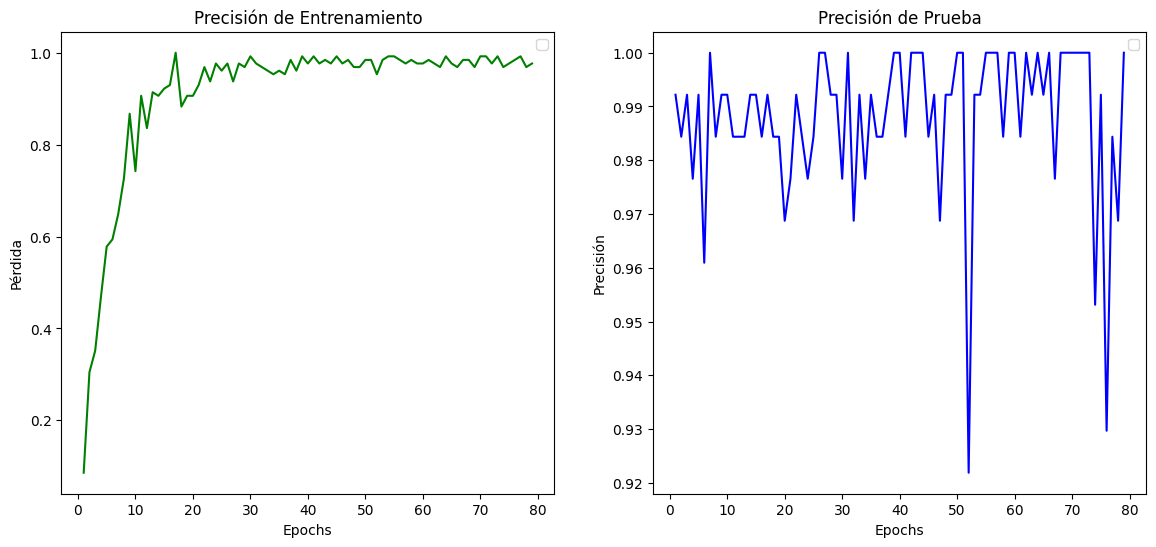

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(train_accuracies, test_accuracies):
	# Ensure both lists have the same length
	min_length = min(len(train_accuracies), len(test_accuracies))
	train_accuracies = train_accuracies[:min_length]
	test_accuracies = test_accuracies[:min_length]
	epochs = range(1, min_length + 1)

	plt.figure(figsize=(14, 6))

	# Subplot for training loss
	plt.subplot(1, 2, 1)
	plt.plot(epochs, train_accuracies, 'g')  # 'g' es el color verde
	plt.xlabel('Epochs')
	plt.ylabel('Pérdida')
	plt.title('Precisión de Entrenamiento')
	plt.legend()

	# Subplot for training and test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(epochs, test_accuracies, 'b')  # 'b' es el color azul
	plt.xlabel('Epochs')
	plt.ylabel('Precisión')
	plt.title('Precisión de Prueba')
	plt.legend()

	plt.show()

plot_metrics(train_acc, acc_test)

# 2. Entrenamiento con Data Aumentation y Pre-Entrenamiento

### Data Aumentation

In [18]:
myaugmentation = t.Compose([
                             t.Pad(4),
                             t.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.75,1.25), shear=15),
                             t.ColorJitter(brightness=(0.2,0.8), contrast=(0.2, 0.8)),
                             mytransforms
])

train = datasets.MNIST(route, train=True, download=False, transform=myaugmentation)
dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

## Entrenamiento

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate
mymodel, train_loss, train_acc = train_model(mymodel, dataloader, optimizer, criterion)

cuda:0
epoch:0, mini-batch: 0: Training loss: 0.756475567817688, accuracy: 0.8359375
epoch:0, mini-batch: 200: Training loss: 0.04574603587388992, accuracy: 0.9765625
epoch:0, mini-batch: 400: Training loss: 0.0376259982585907, accuracy: 0.9921875
epoch:1, mini-batch: 0: Training loss: 0.0483088456094265, accuracy: 0.9765625
epoch:1, mini-batch: 200: Training loss: 0.028477642685174942, accuracy: 0.984375
epoch:1, mini-batch: 400: Training loss: 0.024117223918437958, accuracy: 0.9921875
epoch:2, mini-batch: 0: Training loss: 0.03380460664629936, accuracy: 0.9921875
epoch:2, mini-batch: 200: Training loss: 0.04596387967467308, accuracy: 0.984375
epoch:2, mini-batch: 400: Training loss: 0.00534798251464963, accuracy: 1.0


## Test

In [20]:
testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)
mean_acc, acc_test = test_model(mymodel, testloader)
print(f"Model accuracy on the test set is {mean_acc*100} %")

Model accuracy on the test set is 99.15941455696202 %


# Plot Metrics

/tmp/ipykernel_12547/62463825.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_12547/62463825.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


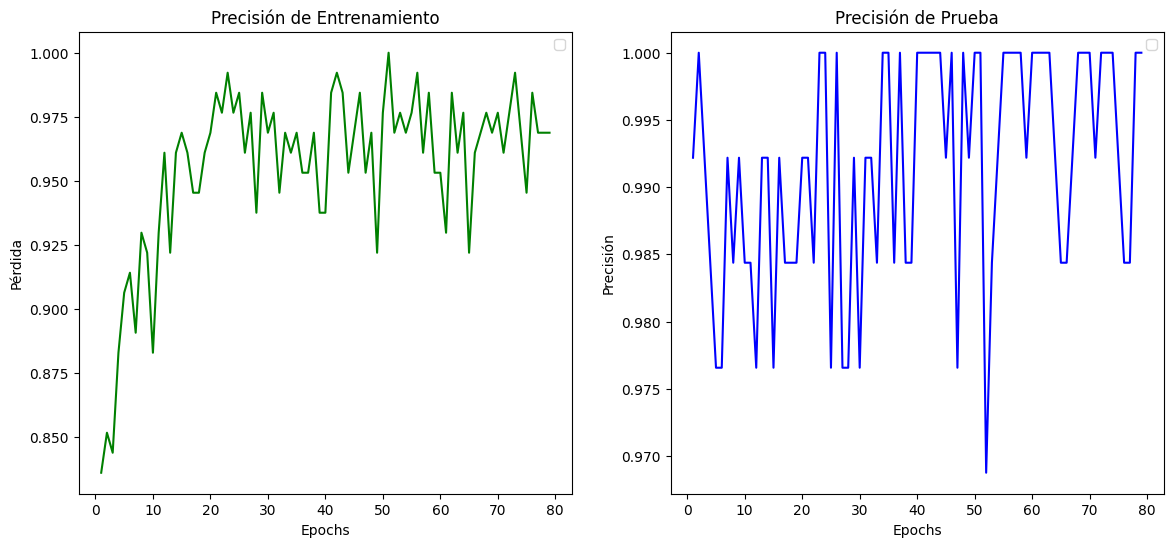

In [21]:
plot_metrics(train_acc, acc_test)

## 3. Clasificacion sin Pre-Entrenamiento (sin data aumentation)

In [22]:
vgg16 = models.vgg16(pretrained=False)
vggf = vgg16.features

mymodel = nn.Sequential(
    vggf,
    nn.AdaptiveAvgPool2d(output_size = 1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)


/home/clown/2-semester/vision_individual/vision_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/clown/2-semester/vision_individual/vision_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

old_layer = mymodel[0][0]
mymodel[0][0] = nn.Conv2d(1, 64, 3, padding=1)
# Redimension a escala de grises, ajustando los pesos sumando los pesos a lo largo del canal de entrada
mymodel[0][0].weight.data = old_layer.weight.sum(dim=1, keepdim=True)
mymodel[0][0].bias.data = old_layer.bias

for name, param in mymodel[0][0].named_parameters():
  print(f"- {name}: {param.shape}")

- weight: torch.Size([64, 3, 3, 3])
- bias: torch.Size([64])
- weight: torch.Size([64, 1, 3, 3])
- bias: torch.Size([64])


## Entrenamiento

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate
mymodel, train_loss, train_acc = train_model(mymodel, dataloader, optimizer, criterion)

cuda:0
epoch:0, mini-batch: 0: Training loss: 2.3021445274353027, accuracy: 0.1015625
epoch:0, mini-batch: 200: Training loss: 2.305063247680664, accuracy: 0.09375
epoch:0, mini-batch: 400: Training loss: 2.2996110916137695, accuracy: 0.1484375
epoch:1, mini-batch: 0: Training loss: 2.305546760559082, accuracy: 0.0703125
epoch:1, mini-batch: 200: Training loss: 2.305112838745117, accuracy: 0.09375
epoch:1, mini-batch: 400: Training loss: 2.2976443767547607, accuracy: 0.1484375
epoch:2, mini-batch: 0: Training loss: 2.3009772300720215, accuracy: 0.1484375
epoch:2, mini-batch: 200: Training loss: 2.3031880855560303, accuracy: 0.078125
epoch:2, mini-batch: 400: Training loss: 2.2966349124908447, accuracy: 0.1328125


## TEST

In [25]:
testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)
mean_acc, acc_test = test_model(mymodel, testloader)
print(f"Model accuracy on the test set is {mean_acc*100} %")

Model accuracy on the test set is 11.362737341772151 %


/tmp/ipykernel_12547/62463825.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_12547/62463825.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


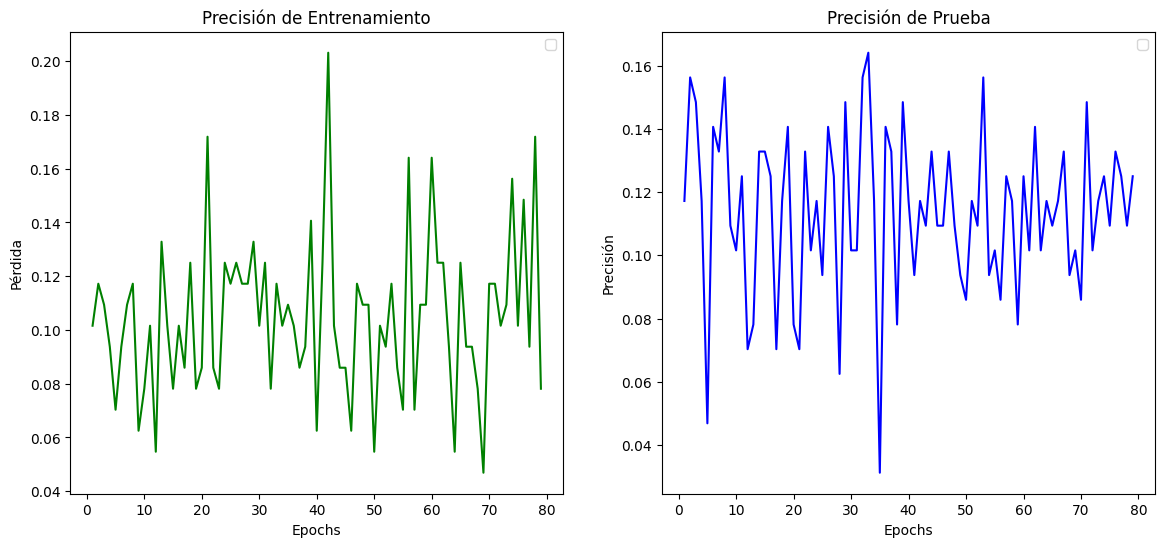

In [26]:
plot_metrics(train_acc, acc_test)

# 2. Entrenamiento sin Pre-Entrenamiento y con Data Aumentation

In [27]:
myaugmentation = t.Compose([
                             t.Pad(4),
                             t.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.75,1.25), shear=15),
                             t.ColorJitter(brightness=(0.2,0.8), contrast=(0.2, 0.8)),
                             mytransforms
])

train = datasets.MNIST(route, train=True, download=False, transform=myaugmentation)
dataloader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

## Entrenamiento

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-4)  # Intizalize the optimizer with the network parameters and learning rate
mymodel, train_loss, train_acc = train_model(mymodel, dataloader, optimizer, criterion)

cuda:0
epoch:0, mini-batch: 0: Training loss: 2.3009307384490967, accuracy: 0.125
epoch:0, mini-batch: 200: Training loss: 1.7185266017913818, accuracy: 0.390625
epoch:0, mini-batch: 400: Training loss: 0.7032875418663025, accuracy: 0.7734375
epoch:1, mini-batch: 0: Training loss: 0.48684361577033997, accuracy: 0.859375
epoch:1, mini-batch: 200: Training loss: 0.3162166476249695, accuracy: 0.9296875
epoch:1, mini-batch: 400: Training loss: 0.11315258592367172, accuracy: 0.96875
epoch:2, mini-batch: 0: Training loss: 0.12081708014011383, accuracy: 0.9609375
epoch:2, mini-batch: 200: Training loss: 0.17450663447380066, accuracy: 0.9375
epoch:2, mini-batch: 400: Training loss: 0.1410052478313446, accuracy: 0.953125


## Test

In [29]:
testloader = DataLoader(test, batch_size=128, shuffle=False, num_workers=2)
mean_acc, acc_test = test_model(mymodel, testloader)
print(f"Model accuracy on the test set is {mean_acc*100} %")

Model accuracy on the test set is 95.43117088607595 %


# Plot Metrics

/tmp/ipykernel_12547/62463825.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_12547/62463825.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


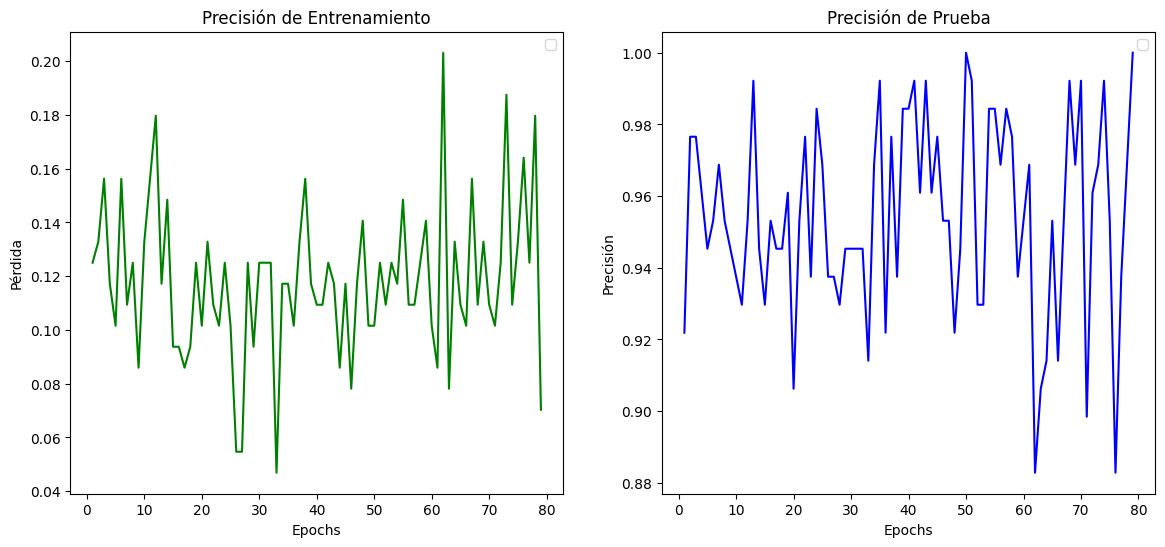

In [31]:
plot_metrics(train_acc, acc_test)